In [1]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import matplotlib.pyplot as plt
from MDAnalysis.analysis.distances import dist
from tqdm import tqdm
import pandas as pd
import pickle
import red

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
def obtain_RMSD(run_numbers):
    """Obtain RMSD for a list of run numbers"""

    filename = 'RMSD.csv'

    if isinstance(run_numbers, int):
        run_numbers = [run_numbers]

    RMSDs = []

    for run_number in run_numbers:
        df = pd.read_csv(f"results/run{run_number}/{filename}")
        time = df['Time (ns)'].to_numpy()
        RMSDs.append(df['RMSD (Angstrom)'].to_numpy())

    RMSDs = np.array(RMSDs)

    return time, np.average(RMSDs, axis=0)

In [3]:
def obtain_RMSF(run_number, species='complex'):

    if species == 'complex':
        filename = 'RMSF.csv'
    elif species == 'BRD4':
        filename = 'RMSF_BRD4.csv'
    else:
        filename = 'RMSF_DCAF16.csv'

    df = pd.read_csv(f"results/run{run_number}/{filename}")

    residx = df['Residue index'].to_numpy()
    RMSF = df['RMSF (Angstrom)'].to_numpy()

    return residx, RMSF

In [4]:
def obtain_av_RMSF(run_numbers, species='complex'):

    RMSFs = []

    for run_number in run_numbers:

        res, rmsf = obtain_RMSF(run_number, species)
        RMSFs.append(rmsf)

    RMSFs = np.array(RMSFs)

    return res, np.average(RMSFs, axis=0), np.std(RMSFs, axis=0)
        

In [5]:
def obtain_CA_idx(u, res_idx):
    """Function to obtain the index of the alpha carbon for a given residue index"""
    
    selection_str = f"protein and resid {res_idx} and name CA"
    
    selected_CA = u.select_atoms(selection_str)

    if len(selected_CA.indices) == 0:
        print('CA not found for the specified residue...')
    
    elif len(selected_CA.indices) > 1:
        print('Multiple CAs found, uh oh...')

    else:  
        return selected_CA.indices[0]

In [6]:
def obtain_distance(run_number, pos1, pos2):
    
    u = mda.Universe('structures/complex.prmtop', f'results/run{run_number}/traj.dcd')
    
    return np.linalg.norm(pos1 - pos2)

In [7]:
def obtain_angle(run_number, pos1, pos2, pos3):

    u = mda.Universe('structures/complex.prmtop', f'results/run{run_number}/traj.dcd')

    return mda.lib.distances.calc_angles(pos1, pos2, pos3)

In [8]:
def obtain_dihedral(run_number, pos1, pos2, pos3, pos4):
    
    u = mda.Universe('structures/complex.prmtop', f'results/run{run_number}/traj.dcd')

    return mda.lib.distances.calc_dihedrals(pos1, pos2, pos3, pos4)

## Plotting RMSD

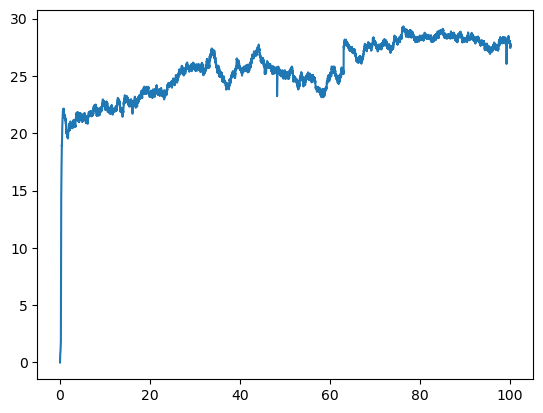

In [12]:
run_numbers = [1,2,3]

time, RMSD = obtain_RMSD(run_numbers)
plt.plot(time, RMSD)

## Plotting RMSF

Try using runs 0, 2 and 4

Text(0, 0.5, 'Average RMSF (Å)')

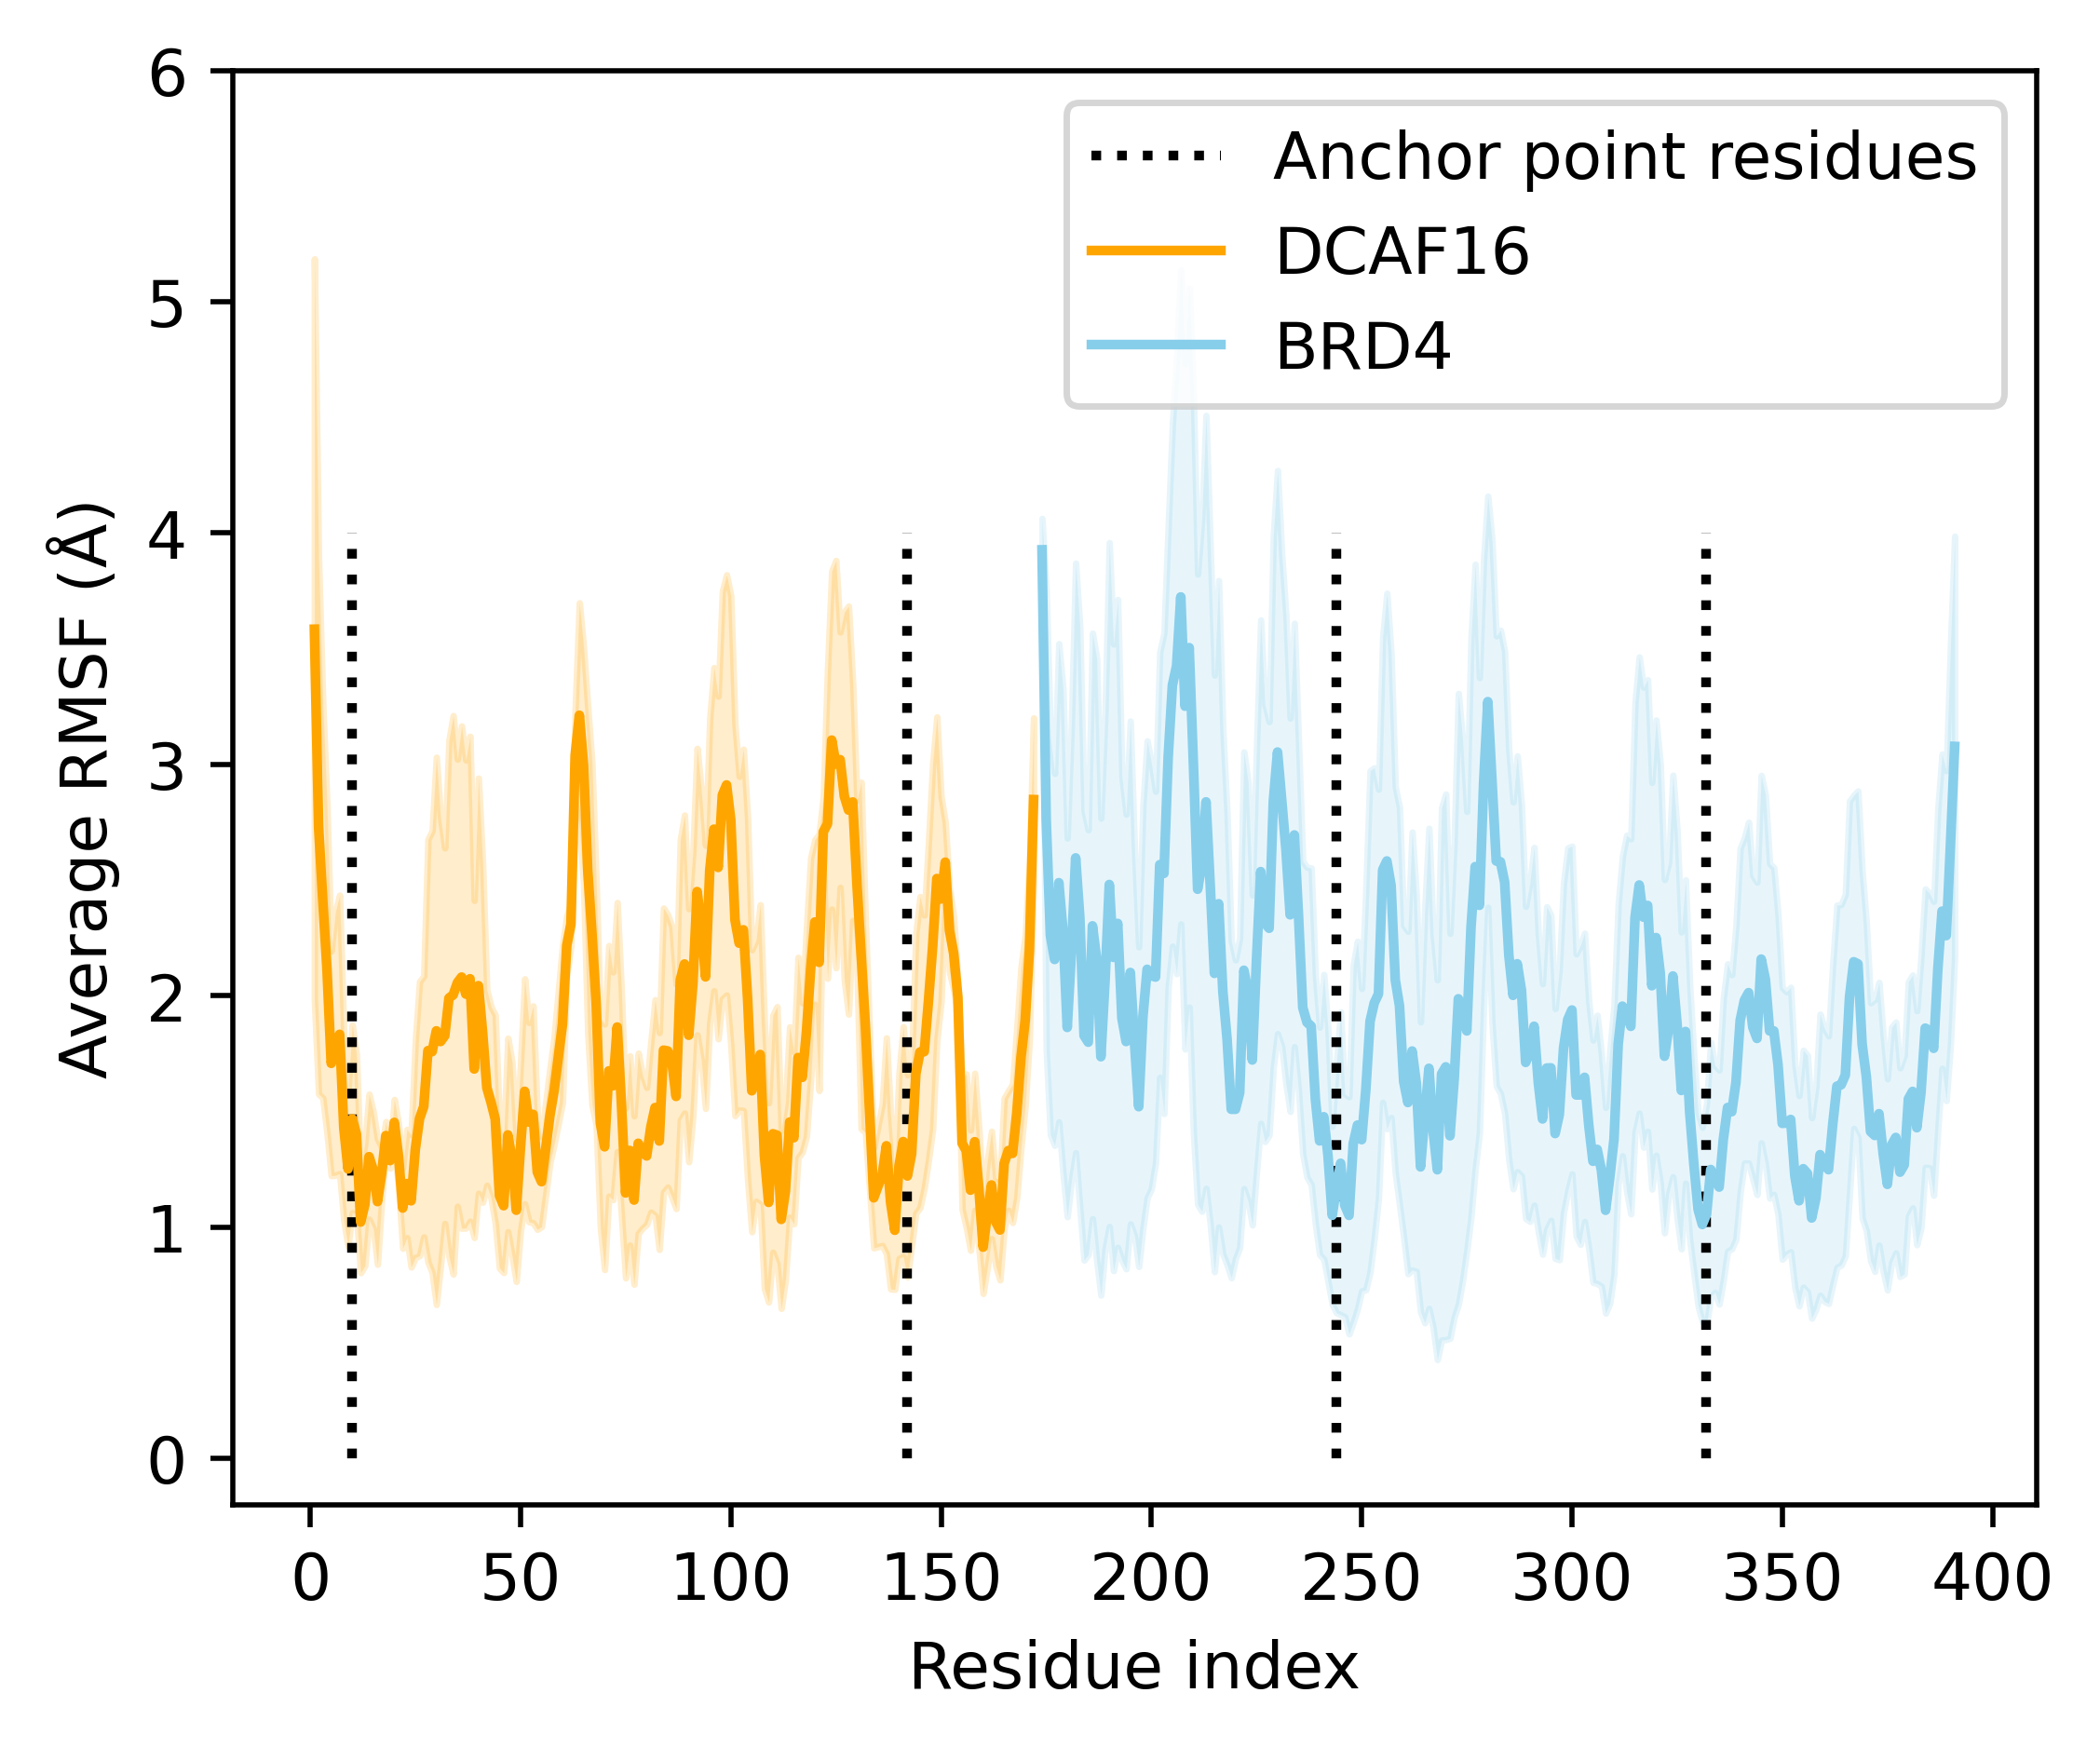

In [20]:
# Boresch_residues = [13, 8, 142, 370, 332, 244]

runs = [0,2,4]

res_DCAF16, av_RMSF_DCAF16, std_RMSF_DCAF16 = obtain_av_RMSF(runs, species='DCAF16')
res_BRD4, av_RMSF_BRD4, std_RMSF_BRD4 = obtain_av_RMSF(runs, species='BRD4')

plt.figure(figsize=(5,4), dpi=500)
plt.vlines([10, 142,  332, 244], ymin=4*[0], ymax=4*[4], colors='k', linestyles='dotted', label='Anchor point residues')
plt.plot(res_DCAF16, av_RMSF_DCAF16, c='orange', label='DCAF16')
plt.fill_between(res_DCAF16, av_RMSF_DCAF16-std_RMSF_DCAF16, av_RMSF_DCAF16+std_RMSF_DCAF16, color='orange', alpha=0.2)
plt.plot(res_BRD4, av_RMSF_BRD4, c='skyblue', label='BRD4')
plt.fill_between(res_BRD4, av_RMSF_BRD4-std_RMSF_BRD4, av_RMSF_BRD4+std_RMSF_BRD4, color='skyblue', alpha=0.2)
plt.legend()
plt.ylim(-0.2, 6.0)
plt.xlabel('Residue index')
plt.ylabel('Average RMSF (Å)')

Text(0, 0.5, 'Average RMSF (Å)')

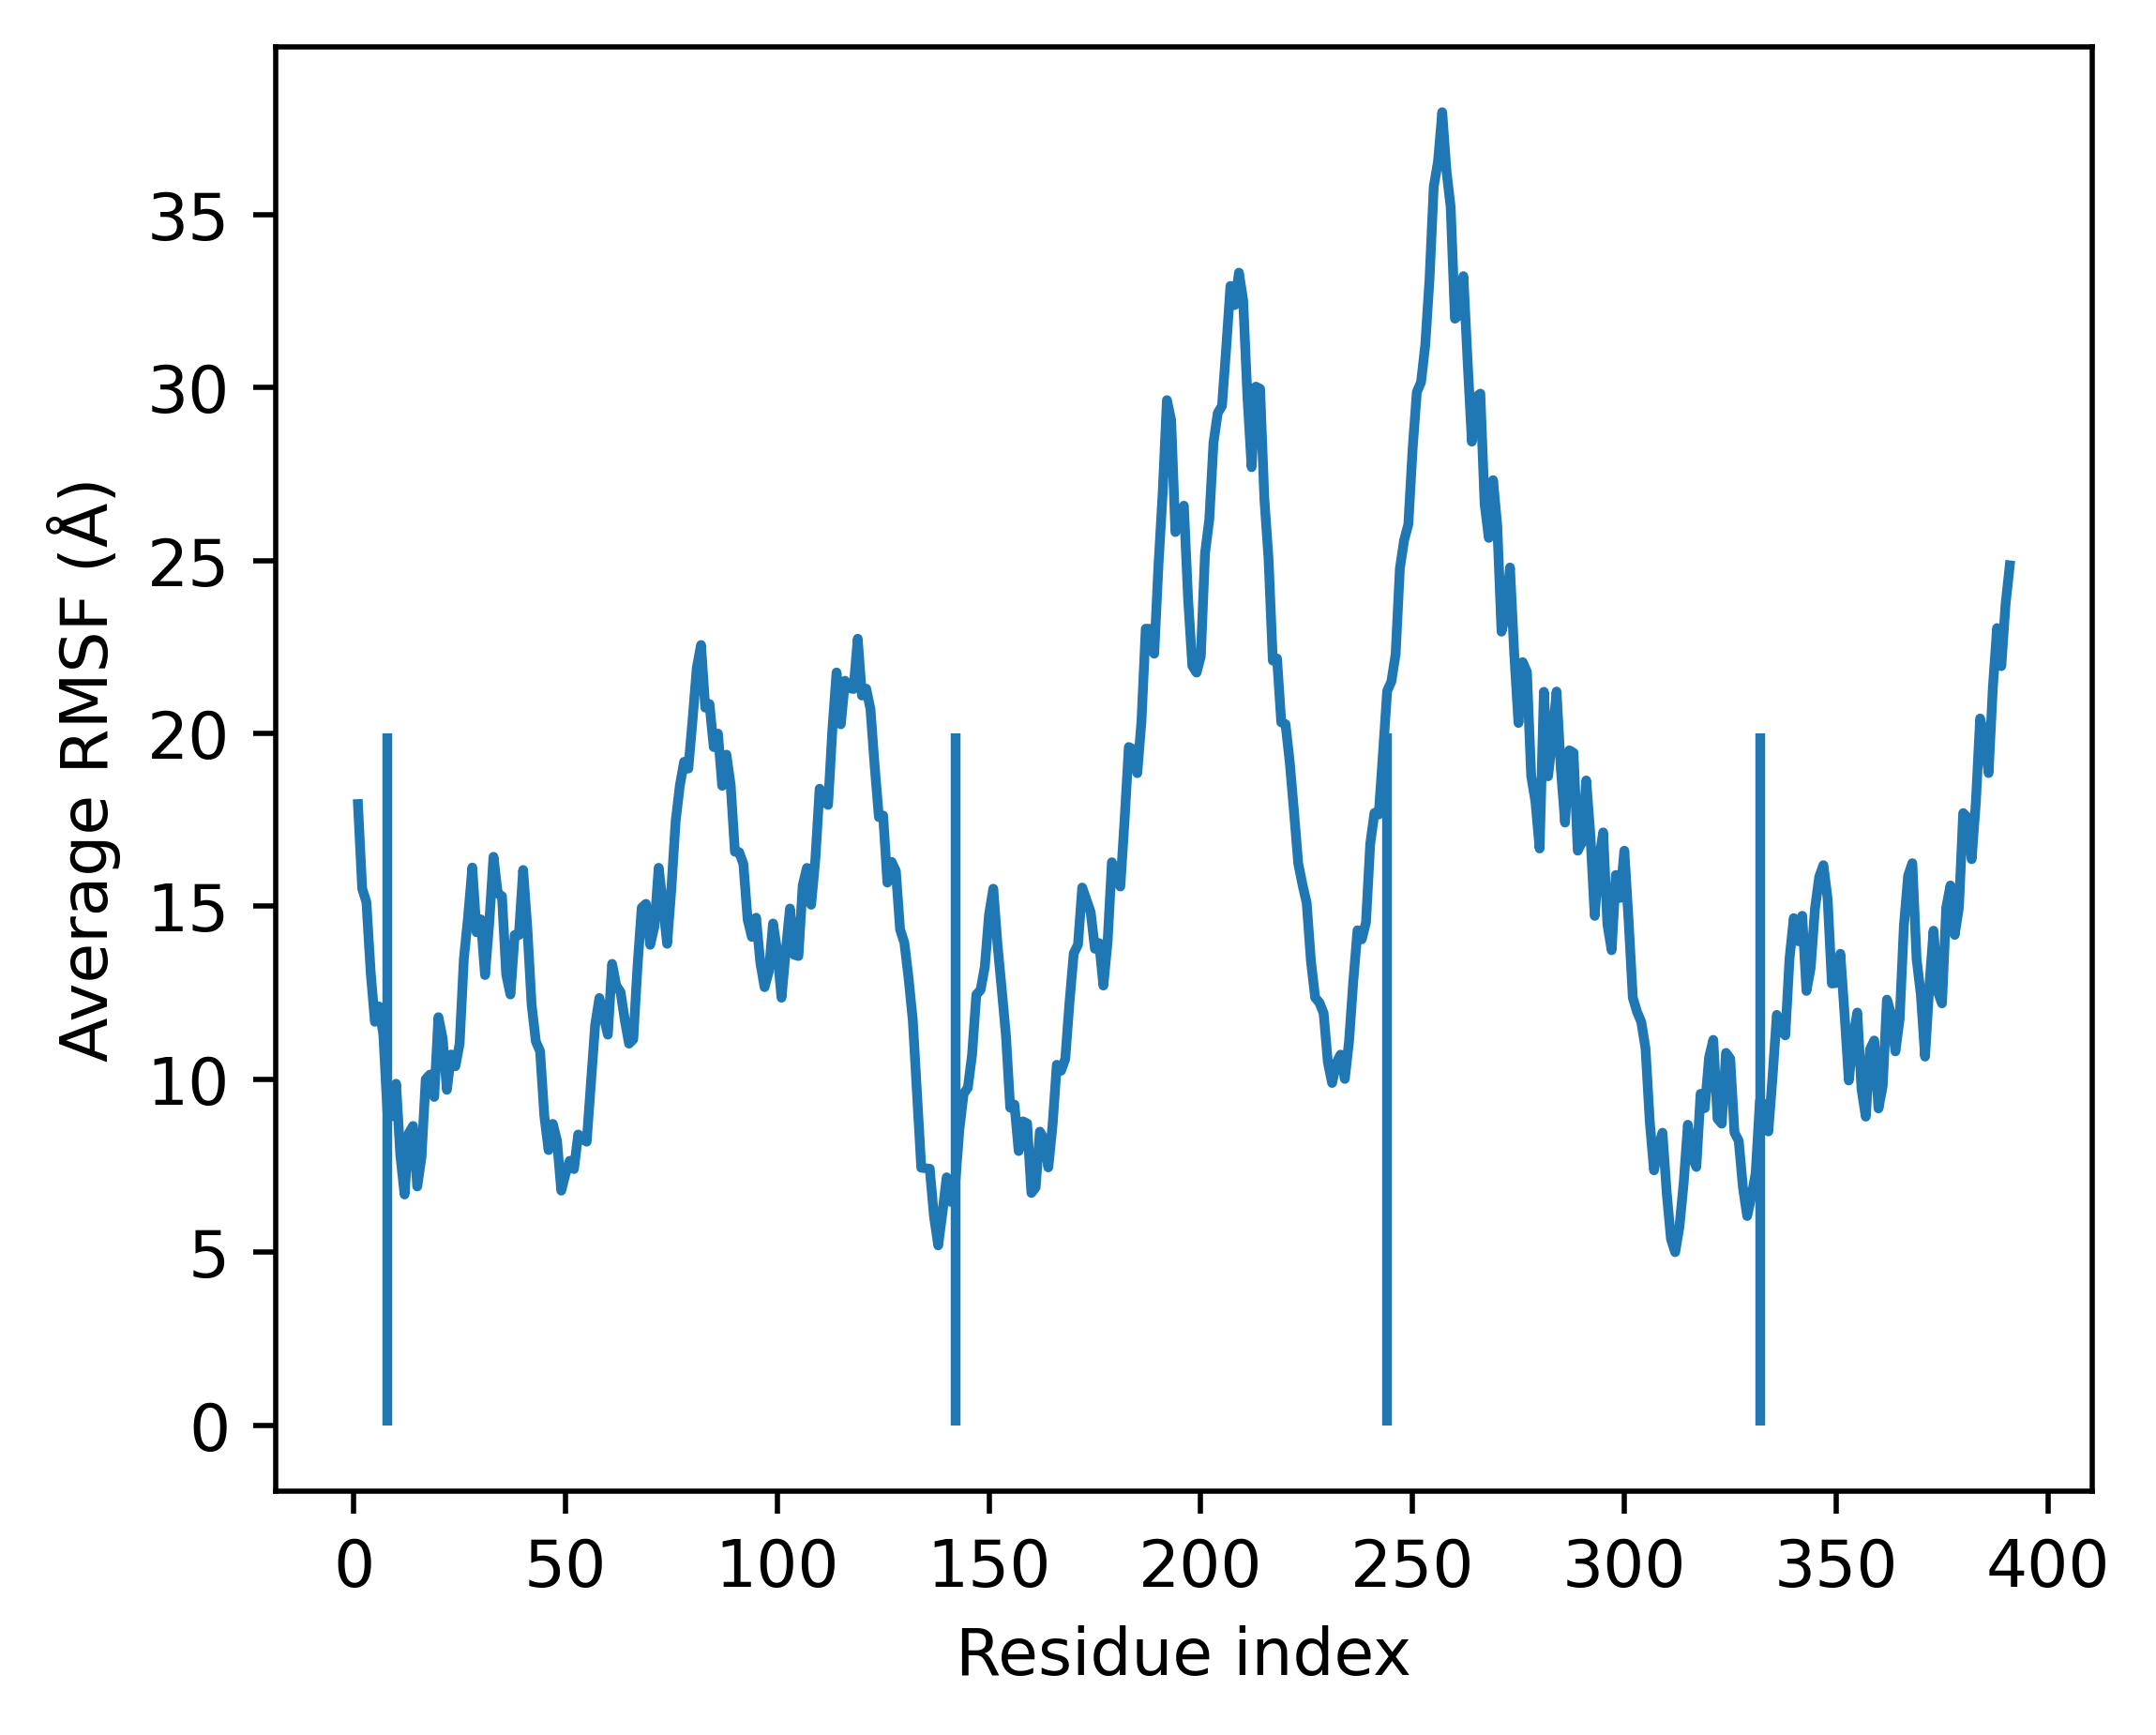

In [146]:
plt.figure(figsize=(5,4), dpi=500)
plt.vlines(x=[8, 142, 332, 244], ymin=[0]*4, ymax=[20]*4)

for n_run in [0]:

    res, rmsf = obtain_RMSF(n_run)
    plt.plot(res, rmsf, label=f'run {n_run}')

# plt.legend()
plt.xlabel('Residue index')
plt.ylabel('Average RMSF (Å)')

### Boresch dof

In [21]:
def obtain_Boresch_dof(run_number, dof):

    boreschfile = f'results/run{run_number}/{dof}.pkl'

    with open(boreschfile, 'rb') as f:
        loaded_data = pickle.load(f)

    frames = loaded_data['Frames']
    time = loaded_data['Time (ns)']
    vals = loaded_data['DOF values']

    return time, vals

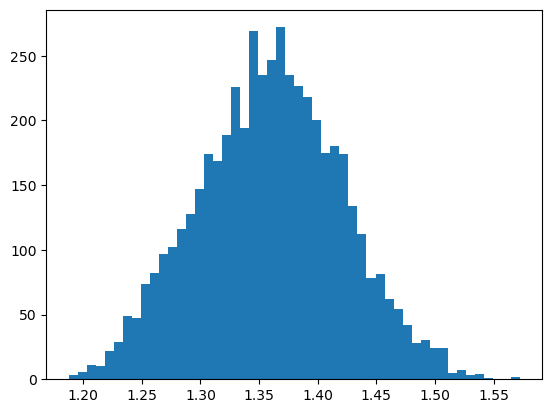

In [22]:
dof = 'thetaA'
run_number = 2
equil_time = 5
cutoff_time = 50

total_time = 100.204
time, vals = obtain_Boresch_dof(run_number, dof)
equil_index = int(len(vals)*equil_time/total_time)-1
cutoff_idx = int(len(vals)*cutoff_time/total_time)-1
time, vals = time[:cutoff_idx]+equil_time, vals[:cutoff_idx]

plt.hist(vals, bins=50)
plt.show()

0.8302449135387212


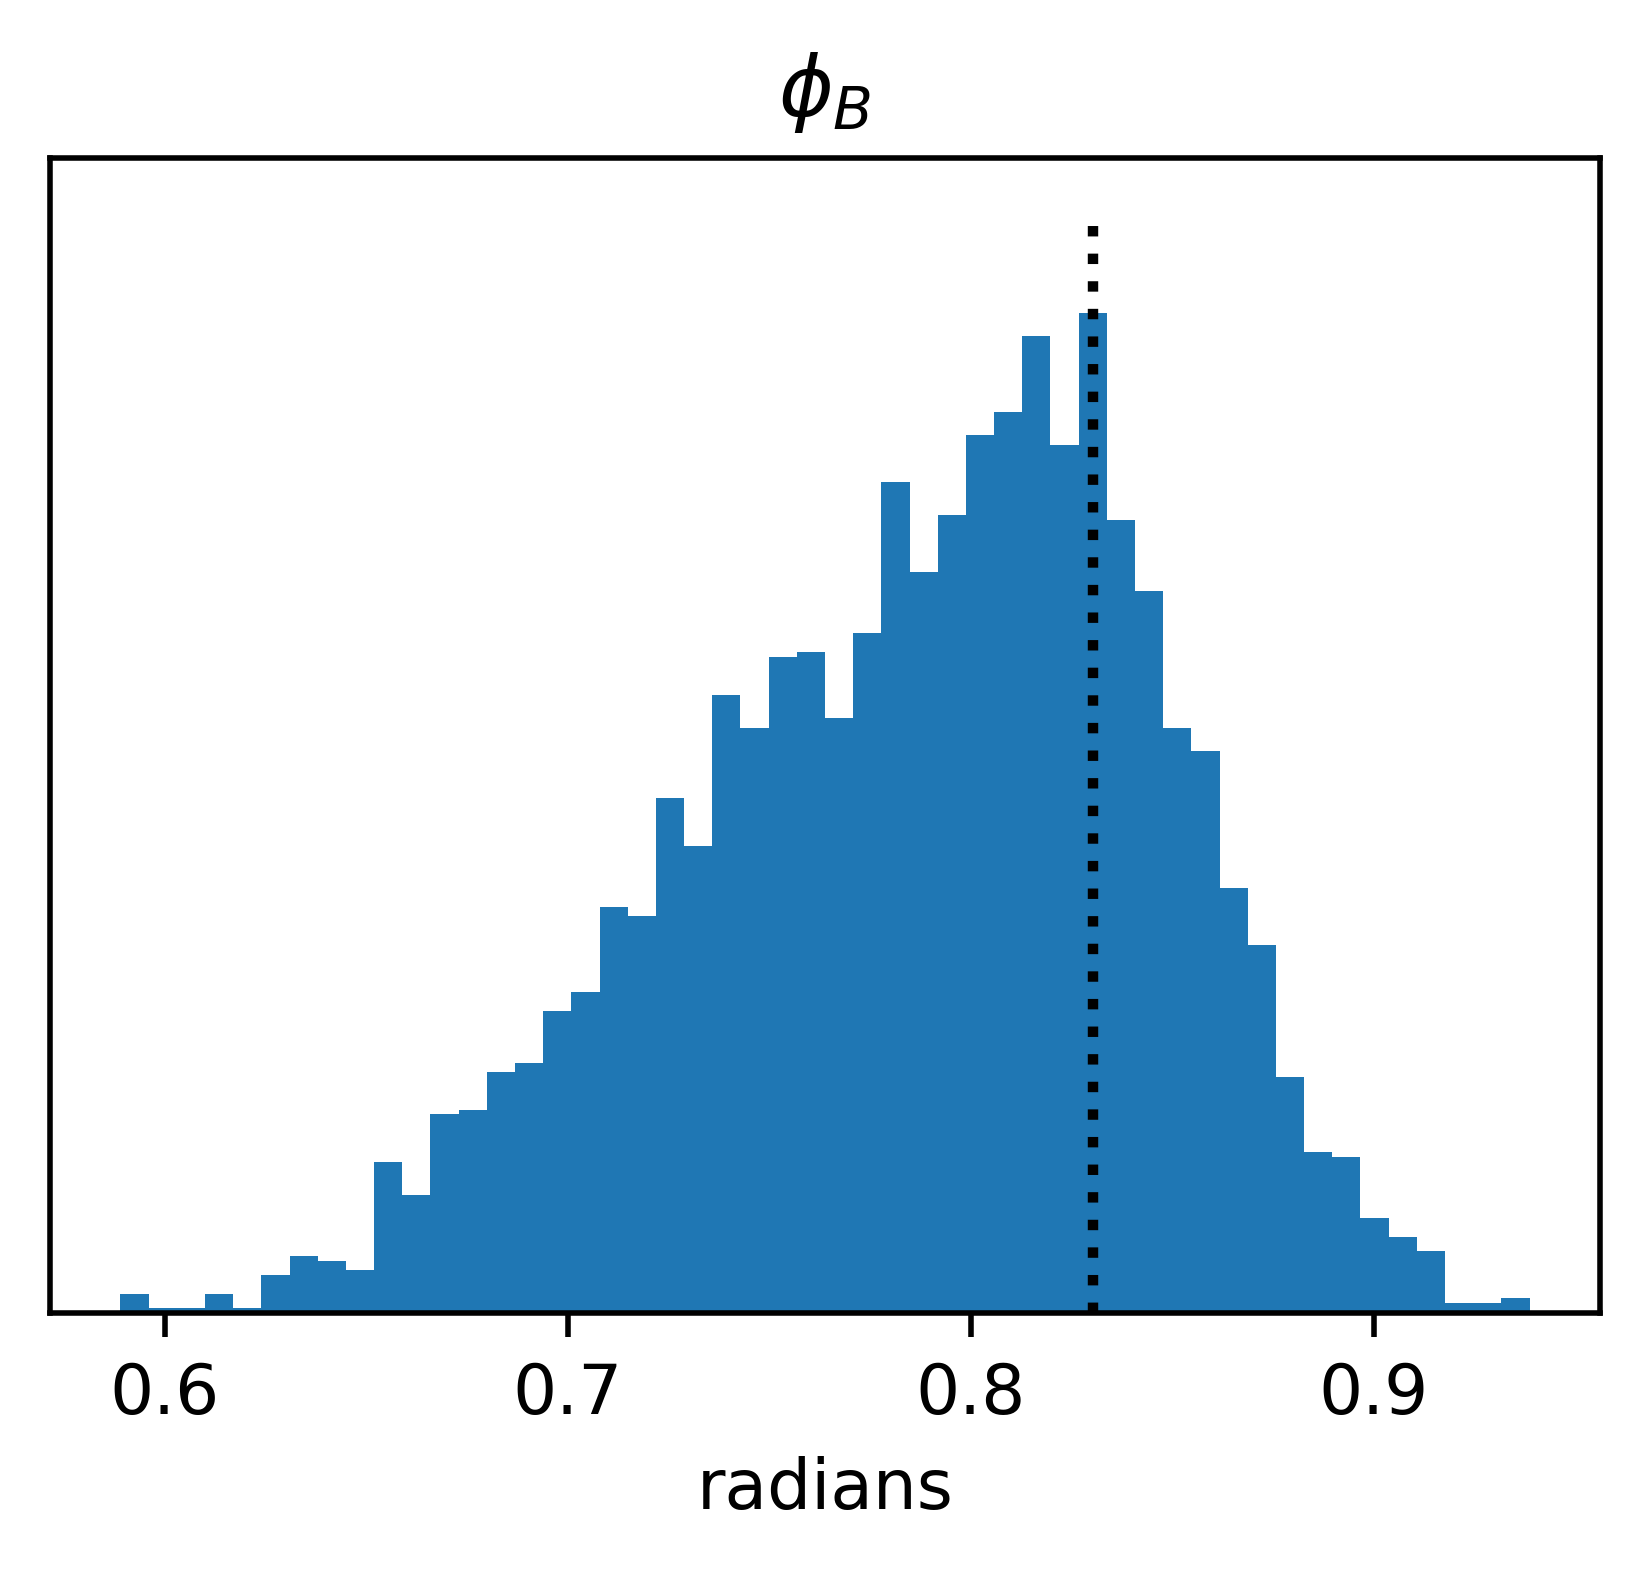

In [42]:
dof = 'phiB'
equil_time = 5
cutoff_time = 40

titles = {'thetaA':'$\Theta _A$', 'thetaB':'$\Theta _B$', 'phiA':'$\phi _A$', 'phiB':'$\phi _B$', 'phiC':'$\phi _C$'}

vals_all = []
plt.figure(figsize=(4,3), dpi=500)
plt.title(titles[dof])

for run_number in [0,2,4]:

    total_time = 100.204
    time, vals = obtain_Boresch_dof(run_number, dof)
    equil_index = int(len(vals)*equil_time/total_time)-1
    cutoff_idx = int(len(vals)*cutoff_time/total_time)-1
    time, vals = time[:cutoff_idx]+equil_time, vals[:cutoff_idx]

    vals_all+=vals

counts, bins, _ = plt.hist(vals, bins=50)

max_index = counts.argmax()
left_edge = bins[max_index]
right_edge = bins[max_index + 1]

print((left_edge+right_edge)/2)

plt.vlines((left_edge+right_edge)/2, ymin=0, ymax=max(counts)*1.1, colors='k', linestyles='dotted', label='Equilibrium value')
plt.yticks([])
plt.xlabel('radians')
# plt.legend()
plt.show()

### Saving equilibrated structure

In [ ]:
u = mda.Universe('structures/complex.prmtop', f'results/run0/traj.dcd')

total_time_ns=100.2
total_frames = 10020
frames_per_ns = total_frames / total_time_ns
frame_15ns = int(frames_per_ns * 15)

# Load the trajectory
u = mda.Universe('structures/complex.prmtop', f'results/run{run_number}/traj.dcd')

u.trajectory[frame_15ns]

u.atoms.write(f'results/structures/15_ns.pdb')

In [221]:
from pymol import cmd

cmd.reinitialize()

cmd.load(f"results/structures/15_ns.pdb", "complex")

cmd.remove("resn HOH")
cmd.remove("resn WAT")
cmd.remove("hydro")
cmd.remove("resn CL")

cmd.save(f"results/structures/complex_eq_noH.pdb")


## Analysis of interface CoM

In [10]:
def obtain_CA_idx(u, res_idx):
    """Function to obtain the index of the alpha carbon for a given residue index"""
    
    selection_str = f"protein and resid {res_idx} and name CA"
    
    selected_CA = u.select_atoms(selection_str)

    if len(selected_CA.indices) == 0:
        print('CA not found for the specified residue...')
    
    elif len(selected_CA.indices) > 1:
        print('Multiple CAs found, uh oh...')

    else:  
        return selected_CA.indices[0]

def obtain_distance(pos1, pos2):
    """Obtain the distance between two coordinates"""
    return np.linalg.norm(pos1 - pos2)

In [11]:
u = mda.Universe('structures/complex.prmtop', f'structures/complex.inpcrd')

rec_group = [4, 18, 37, 56, 81, 96, 107, 126, 136, 160, 177, 193, 215, 226, 245, 264, 286, 307, 318, 332, 346, 400, 406, 425, 447, 453, 521, 610, 629, 649, 655, 666, 688, 694, 710, 727, 789, 941, 1872, 1899, 1905, 1920, 1941, 1960, 1999, 2026, 2057, 2068, 2084, 2095, 2102, 2112, 2123, 2133, 2140, 2164, 2183, 2197, 2219, 2463]
lig_group = [3032, 3054, 3071, 3088, 3333, 3360, 3366, 3378, 3442, 4051, 4072, 4091, 4112, 4126, 4156, 4162, 4169, 4181, 4193, 4212, 4228, 4247, 4264, 4274, 4289, 4824, 4834, 4856, 4878, 4895, 4905, 4915, 4936, 4946, 4978, 5025, 5055, 5061, 5077, 5089, 5105, 5120, 5130, 5149, 5156, 5175, 5192, 5204, 5890, 5911, 5933, 5953, 5965, 5982, 5997, 6013, 6039]

rec_atoms = u.atoms[rec_group]
lig_atoms = u.atoms[lig_group]

# Test that all atoms are CAs
for atom in rec_atoms+lig_atoms:
    if atom.name != 'CA':
        raise ValueError('Select only CA atoms as anchorpoints')

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)


In [14]:
lig_atoms.resids

array([190, 191, 192, 193, 208, 209, 210, 211, 214, 251, 252, 253, 254,
       255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 298,
       299, 300, 301, 302, 303, 304, 305, 306, 307, 310, 311, 312, 313,
       314, 315, 316, 317, 318, 319, 320, 321, 322, 364, 365, 366, 368,
       369, 370, 371, 372, 374])

In [23]:
CoM_sep_data = {}

for n_run in [0,2,4]:
    sep = []
    u = mda.Universe('structures/complex.prmtop', f'results/run{n_run}/traj.dcd')
    
    total_frames = 10020
    frames_per_ns = total_frames / 100.2
    frames_40ns = int(frames_per_ns * 40)

    for ts in tqdm(u.trajectory[:frames_40ns], total=frames_40ns, desc='Frames analysed'):
    
        rec_atoms = u.atoms[rec_group]
        lig_atoms = u.atoms[lig_group] 

        rec_COM = rec_atoms.center_of_mass()
        lig_COM = lig_atoms.center_of_mass()

        sep.append(obtain_distance(rec_COM, lig_COM))

    CoM_sep_data[n_run] = sep

/home/benedicttan/miniconda3/envs/openbiosim/lib/python3.10/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)
/home/benedicttan/miniconda3/envs/openbiosim/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
Frames analysed: 100%|██████████| 4000/4000 [00:22<00:00, 176.52it/s]


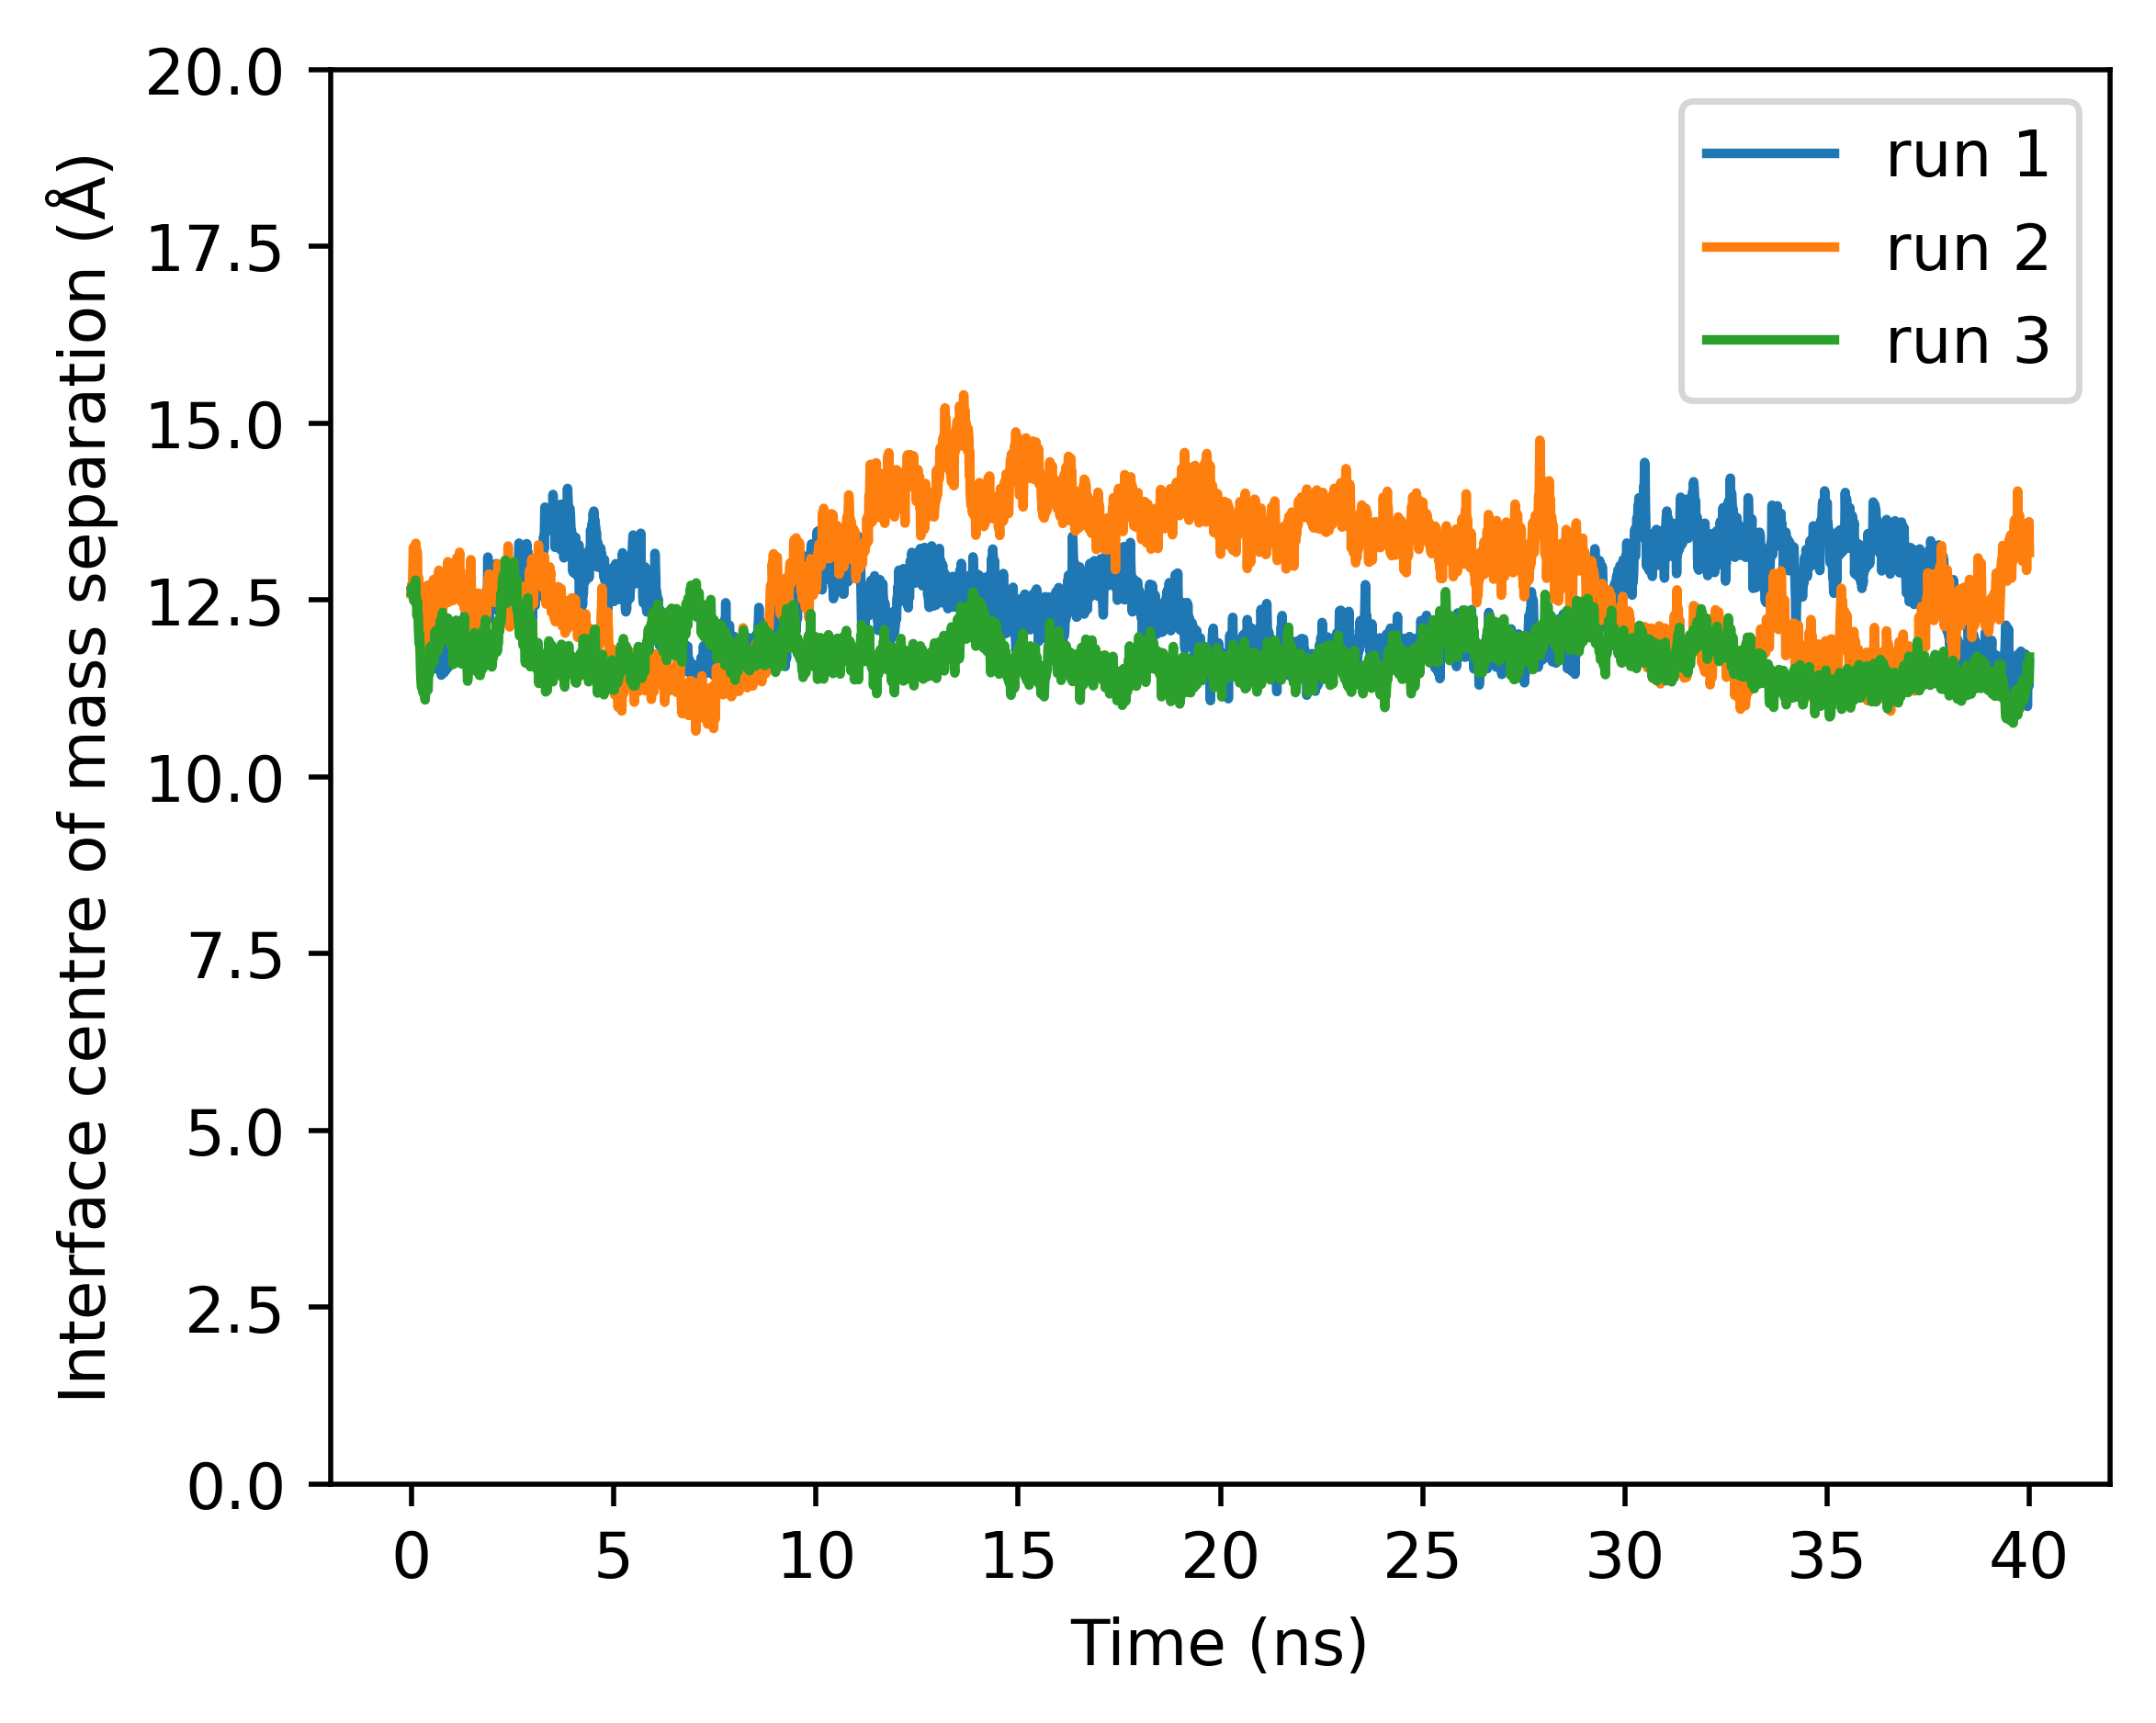

In [42]:
plt.figure(figsize=(5,4), dpi=500)

labels = {0:1, 2:2, 4:3}

for n_run in [0,2,4]:
    x = np.linspace(0,40,len(CoM_sep_data[n_run]))
    plt.plot(x, CoM_sep_data[n_run], label=f"run {labels[n_run]}")

plt.ylim(0,20)
plt.ylabel('Interface centre of mass separation (Å)')
plt.xlabel('Time (ns)')
plt.legend()
plt.show()

Printing the interface residue indices

In [46]:
u = mda.Universe('structures/complex.prmtop', f'structures/complex.inpcrd')

rec_group = [4, 18, 37, 56, 81, 96, 107, 126, 136, 160, 177, 193, 215, 226, 245, 264, 286, 307, 318, 332, 346, 400, 406, 425, 447, 453, 521, 610, 629, 649, 655, 666, 688, 694, 710, 727, 789, 941, 1872, 1899, 1905, 1920, 1941, 1960, 1999, 2026, 2057, 2068, 2084, 2095, 2102, 2112, 2123, 2133, 2140, 2164, 2183, 2197, 2219, 2463]
lig_group = [3032, 3054, 3071, 3088, 3333, 3360, 3366, 3378, 3442, 4051, 4072, 4091, 4112, 4126, 4156, 4162, 4169, 4181, 4193, 4212, 4228, 4247, 4264, 4274, 4289, 4824, 4834, 4856, 4878, 4895, 4905, 4915, 4936, 4946, 4978, 5025, 5055, 5061, 5077, 5089, 5105, 5120, 5130, 5149, 5156, 5175, 5192, 5204, 5890, 5911, 5933, 5953, 5965, 5982, 5997, 6013, 6039]

rec_atoms = u.atoms[rec_group]
lig_atoms = u.atoms[lig_group]

rec_res = [resid for resid in rec_atoms.resids]
lig_res = [resid for resid in lig_atoms.resids]
print(lig_res)

[190, 191, 192, 193, 208, 209, 210, 211, 214, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 364, 365, 366, 368, 369, 370, 371, 372, 374]


/home/benedicttan/miniconda3/envs/openbiosim/lib/python3.10/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)
